In [1]:
import numpy
import logging
import pycbc
from pycbc.inference import io
from pycbc.inference import models

In [2]:
%matplotlib notebook
from matplotlib import pyplot

In [3]:
pycbc.init_logging(True)

In [4]:
fn = '../BH-Spectroscopy-GW190521/posteriors/kerr/220_330/KERR-220_330-07MS.hdf'
fp = io.loadfile(fn, 'r')

In [5]:
cp = fp.read_config_file()
psds = fp.read_psds()
data = fp.read_data()

In [6]:
model = models.read_from_config(cp, data=data, psds=psds)

2021-08-27 22:26:05,375 Setting up priors for each parameter
2021-08-27 22:26:05,379 No sampling_params section read from config file
2021-08-27 22:26:05,380 Loading waveform transforms
2021-08-27 22:26:05,385 Determining analysis times to use
2021-08-27 22:26:05,386 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-08-27 22:26:05,386 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-08-27 22:26:05,387 Padding V1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.


In [7]:
samples = fp.read_samples(list(fp['samples'].keys()))

In [8]:
maxidx = samples.loglikelihood.argmax()
params = {p: samples[p][maxidx] for p in model.variable_params}

In [9]:
model.update(**params)
print(model.loglikelihood)

-1240538.0178232198


In [10]:
def testlogl():
    model.update(**params)
    return model.loglikelihood

In [11]:
%timeit testlogl()

184 ms ± 5.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# try calculating 
# -(1/2)<d-h, d-h> = <h, d>/2 + <d, h>/2 - <h, h>/2 - <d, d>/2
wfs = model.get_waveforms()
gated_wfs = model.get_gated_waveforms()
dfs = model.get_data()
gated_dfs = model.get_gated_data()

logl = 0.
for det in wfs:
    invpsd = model._invpsds[det]
    h = wfs[det]
    gated_h = gated_wfs[det]
    gated_h *= invpsd
    d = dfs[det]
    gated_d = gated_dfs[det]
    gated_d *= invpsd
    slc = slice(model._kmin[det], model._kmax[det])
    hd = h[slc].inner(gated_d[slc]).real
    dh = d[slc].inner(gated_h[slc]).real
    hh = h[slc].inner(gated_h[slc]).real
    dd = d[slc].inner(gated_d[slc]).real
    logl += 2 * invpsd.delta_f * (hd + dh - hh - dd)

print(logl)

-1240538.0178208796


# Try the marginalized polarization

In [12]:
cp = fp.read_config_file()
cp.set('model', 'name', 'gated_gaussian_margpol')
cp.remove_option('variable_params', 'polarization')
cp.remove_section('prior-polarization')
margmodel = models.read_from_config(cp, data=data, psds=psds)

2021-08-27 22:27:24,047 Setting up priors for each parameter
2021-08-27 22:27:24,050 No sampling_params section read from config file
2021-08-27 22:27:24,052 Loading waveform transforms
2021-08-27 22:27:24,068 Determining analysis times to use
2021-08-27 22:27:24,071 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-08-27 22:27:24,072 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-08-27 22:27:24,073 Padding V1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.


In [13]:
print(params.pop('polarization'))
margmodel.update(**params)

5.604652336540312


In [15]:
margmodel.loglikelihood

-1240541.542619468

In [16]:
margmodel.current_stats

{'logjacobian': nan,
 'logprior': nan,
 'loglikelihood': -1240541.5426231564,
 'maxl_polarization': 2.4654741145289267,
 'maxl_logl': -1240538.0139600916}

In [16]:
def testlogl():
    margmodel.update(**params)
    return margmodel.loglikelihood

In [17]:
%timeit testlogl()

330 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 221 effect

In [31]:
# does this fix the 221 issues?
fn = '../injections/imrdraws/inj100-batch_runs/inj06/samples-220_221-21.hdf'
fp = io.loadfile(fn, 'r')

In [32]:
cp = fp.read_config_file()
cp.set('model', 'name', 'gated_gaussian_margpol')
cp.remove_option('variable_params', 'polarization')
cp.remove_section('prior-polarization')
psds = fp.read_psds()
data = fp.read_data()

In [33]:
model = models.read_from_config(cp, data=data, psds=psds)

2021-08-27 16:16:14,324 Setting up priors for each parameter
2021-08-27 16:16:14,328 No sampling_params section read from config file
2021-08-27 16:16:14,329 Loading waveform transforms
2021-08-27 16:16:14,338 Determining analysis times to use
2021-08-27 16:16:14,338 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-08-27 16:16:14,339 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-08-27 16:16:14,339 Padding V1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.


In [34]:
samples = fp.read_samples(list(fp['samples'].keys()))

In [35]:
maxidx = samples.loglikelihood.argmax()
params = {p: samples[p][maxidx] for p in model.variable_params}
print(params)

{'final_mass': 499.9194837717015, 'final_spin': -0.9899979739166659, 'inclination': 1.6764699640701861, 'logamp220': -19.00001729065916, 'phi220': 0.4863014617095732, 'amp221': 1.702286795013982, 'phi221': 2.166519267257661}


In [36]:
model.update(**params)
logl221 = model.loglikelihood
print(logl221)

-2084405.5169952214


In [37]:
# try calculating 
# -(1/2)<d-h, d-h> = <h, d>/2 + <d, h>/2 - <h, h>/2 - <d, d>/2
wfs = model.get_waveforms()
gated_wfs = model.get_gated_waveforms()
dfs = model.get_data()
gated_dfs = model.get_gated_data()

logl = 0.
for det in wfs:
    invpsd = model._invpsds[det]
    h = wfs[det]
    gated_h = gated_wfs[det]
    gated_h *= invpsd
    d = dfs[det]
    gated_d = gated_dfs[det]
    gated_d *= invpsd
    slc = slice(model._kmin[det], model._kmax[det])
    hd = h[slc].inner(gated_d[slc]).real
    dh = d[slc].inner(gated_h[slc]).real
    hh = h[slc].inner(gated_h[slc]).real
    dd = d[slc].inner(gated_d[slc]).real
    logl += 2 * invpsd.delta_f * (hd + dh - hh - dd)

print(logl)

TypeError: can't multiply sequence by non-int of type 'FrequencySeries'

<IPython.core.display.Javascript object>


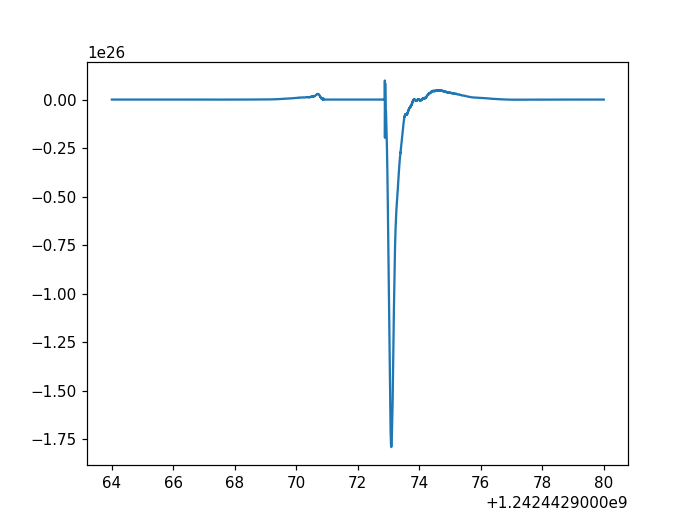

<IPython.core.display.Javascript object>


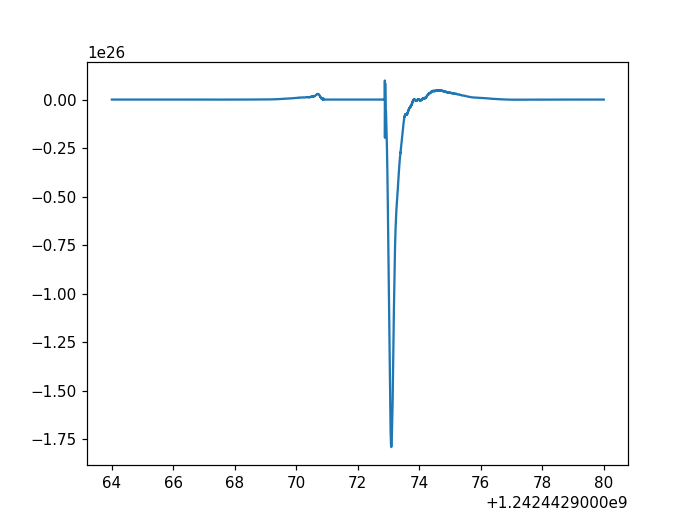

In [19]:
fig, ax = pyplot.subplots()
h = wfs['L1'].to_timeseries()
ax.plot(h.sample_times, h)
fig.show()

fig, ax = pyplot.subplots()
gh = gated_wfs['L1'].to_timeseries()
ax.plot(gh.sample_times, gh)
fig.show()

In [20]:
fp.close()

### 220

In [38]:
fn = '../injections/imrdraws/inj100-batch_runs/inj06/samples-220-21.hdf'
fp = io.loadfile(fn, 'r')

In [39]:
cp = fp.read_config_file()
cp.set('model', 'name', 'gated_gaussian_margpol')
cp.remove_option('variable_params', 'polarization')
cp.remove_section('prior-polarization')
psds = fp.read_psds()
data = fp.read_data()

In [40]:
model = models.read_from_config(cp, data=data, psds=psds)

2021-08-27 16:16:28,738 Setting up priors for each parameter
2021-08-27 16:16:28,742 No sampling_params section read from config file
2021-08-27 16:16:28,743 Loading waveform transforms
2021-08-27 16:16:28,752 Determining analysis times to use
2021-08-27 16:16:28,753 Padding H1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-08-27 16:16:28,754 Padding L1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-08-27 16:16:28,754 Padding V1 analysis start and end times by 4 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.


In [41]:
samples = fp.read_samples(list(fp['samples'].keys()))

In [42]:
maxidx = samples.loglikelihood.argmax()
params = {p: samples[p][maxidx] for p in model.variable_params}
print(params)

{'final_mass': 238.41479215393244, 'final_spin': 0.49701360475486744, 'inclination': 1.769247704774201, 'logamp220': -20.58413559316471, 'phi220': 5.258523743983401}


In [43]:
model.update(**params)
logl220 = model.loglikelihood
print(logl220)

-2084787.4209588033


In [44]:
logl221 - logl220

381.90396358189173

In [27]:
# try calculating 
# -(1/2)<d-h, d-h> = <h, d>/2 + <d, h>/2 - <h, h>/2 - <d, d>/2
wfs = model.get_waveforms()
gated_wfs = model.get_gated_waveforms()
dfs = model.get_data()
gated_dfs = model.get_gated_data()

logl = 0.
for det in wfs:
    invpsd = model._invpsds[det]
    h = wfs[det]
    gated_h = gated_wfs[det]
    gated_h *= invpsd
    d = dfs[det]
    gated_d = gated_dfs[det]
    gated_d *= invpsd
    slc = slice(model._kmin[det], model._kmax[det])
    hd = h[slc].inner(gated_d[slc]).real
    dh = d[slc].inner(gated_h[slc]).real
    hh = h[slc].inner(gated_h[slc]).real
    dd = d[slc].inner(gated_d[slc]).real
    logl += 2 * invpsd.delta_f * (hd + dh - hh - dd)

print(logl)

2.224556105493154e+46


<IPython.core.display.Javascript object>


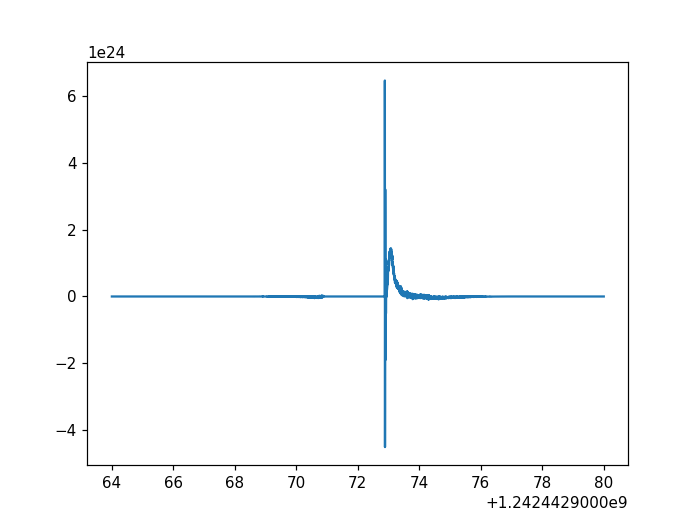

<IPython.core.display.Javascript object>


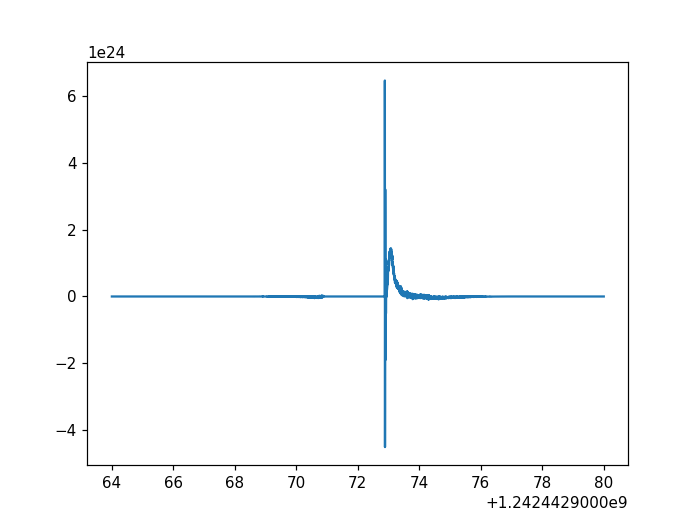

In [28]:
fig, ax = pyplot.subplots()
h = wfs['L1'].to_timeseries()
ax.plot(h.sample_times, h)
fig.show()

fig, ax = pyplot.subplots()
gh = gated_wfs['L1'].to_timeseries()
ax.plot(gh.sample_times, gh)
fig.show()

In [29]:
fp.close()